In [1]:
import re
import pickle
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

from utils import camelcase_to_underscore


sns.set(style="white", palette="muted", color_codes=True)

### Read Data

In [2]:
# Full
# df = pd.read_csv('input/train_V2.csv')
# Sample
df = pd.read_csv('input/train_V2.csv', nrows=10000)
df.columns = [camelcase_to_underscore(col) for col in df.columns]
display(df.head(), df.shape, list(df.columns))

,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


(10000, 29)

['id',
 'group_id',
 'match_id',
 'assists',
 'boosts',
 'damage_dealt',
 'dbn_os',
 'headshot_kills',
 'heals',
 'kill_place',
 'kill_points',
 'kills',
 'kill_streaks',
 'longest_kill',
 'match_duration',
 'match_type',
 'max_place',
 'num_groups',
 'rank_points',
 'revives',
 'ride_distance',
 'road_kills',
 'swim_distance',
 'team_kills',
 'vehicle_destroys',
 'walk_distance',
 'weapons_acquired',
 'win_points',
 'win_place_perc']

### Drop NaN Target observations

In [3]:
df.drop(df[df['win_place_perc'].isnull()].index, inplace=True)

### Select Numerical Features

In [4]:
id_features = ['id', 'group_id', 'match_id']
categorical_features = ['match_type', ]
target_feature = 'win_place_perc'
base_features = [col for col in df.columns if col not in id_features + categorical_features + [target_feature]] 

### Count Unique Values

In [5]:
df['group_id'].nunique(), df['match_id'].nunique(), df['match_type'].nunique()

(9971, 9059, 15)

### Explore Target

count    10000.000000
mean         0.472508
std          0.307031
min          0.000000
25%          0.200000
50%          0.458300
75%          0.740700
max          1.000000
Name: win_place_perc, dtype: float64

/Users/dmitrymikhailovich_/cnt/pubg-kaggle/.direnv/python-3.6.3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


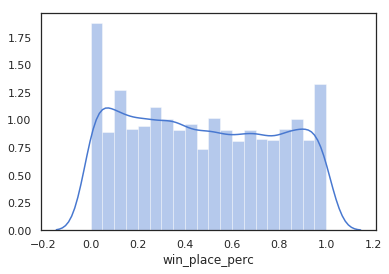

In [6]:
display(df[target_feature].describe())
sns.distplot(df[target_feature])
plt.show()

In [7]:
df.head()

,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [8]:
from features import GroupAggregatedFeatureGenerator

df_features = GroupAggregatedFeatureGenerator(base_features).fit_transform(df)

In [9]:
df_features.columns

Index(['match_id', 'group_id', 'mean_group_assists', 'mean_group_boosts',
       'mean_group_damage_dealt', 'mean_group_dbn_os',
       'mean_group_headshot_kills', 'mean_group_heals',
       'mean_group_kill_place', 'mean_group_kill_points',
       ...
       'rank_min_group_rank_points', 'rank_min_group_revives',
       'rank_min_group_ride_distance', 'rank_min_group_road_kills',
       'rank_min_group_swim_distance', 'rank_min_group_team_kills',
       'rank_min_group_vehicle_destroys', 'rank_min_group_walk_distance',
       'rank_min_group_weapons_acquired', 'rank_min_group_win_points'],
      dtype='object', length=150)

In [10]:
df_features

,match_id,group_id,mean_group_assists,mean_group_boosts,mean_group_damage_dealt,mean_group_dbn_os,mean_group_headshot_kills,mean_group_heals,mean_group_kill_place,mean_group_kill_points,...,rank_min_group_rank_points,rank_min_group_revives,rank_min_group_ride_distance,rank_min_group_road_kills,rank_min_group_swim_distance,rank_min_group_team_kills,rank_min_group_vehicle_destroys,rank_min_group_walk_distance,rank_min_group_weapons_acquired,rank_min_group_win_points
index,,,,,,,,,,,,,,,,,,,,,
0,a10357fd1a4a91,4d4b580de459be,0.0,0.0,0.000,0.0,0.0,0.0,60.0,1241.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,aeb375fc57110c,684d5656442f9e,0.0,0.0,91.470,0.0,0.0,0.0,57.0,0.0,...,0.500000,0.750000,1.000000,0.750000,1.000000,0.750000,0.750000,1.000000,0.500000,0.750000
2,110163d8bb94ae,6a4a42c3245a74,1.0,0.0,68.000,0.0,0.0,0.0,47.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,f1f1f4ef412d7e,a930a9c79cd721,0.0,0.0,32.900,0.0,0.0,0.0,75.0,0.0,...,0.333333,0.666667,0.666667,0.666667,0.666667,0.500000,0.666667,0.333333,0.500000,0.666667
4,6dc8ff871e21e6,de04010b3458dd,0.0,0.0,100.000,0.0,0.0,0.0,45.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,bac52627a12114,289a6836a88d27,0.0,0.0,100.000,1.0,1.0,0.0,44.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,a8274e903927a2,2c485a1ad3d0f1,0.0,0.0,0.000,0.0,0.0,0.0,96.0,1262.0,...,0.666667,0.666667,0.500000,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333,0.833333
7,292611730ca862,eaba5fcb7fc1ae,0.0,0.0,8.538,0.0,0.0,0.0,48.0,1000.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,df014fbee741c6,47cfbb04e1b1a2,0.0,0.0,51.600,0.0,0.0,0.0,64.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
